<a href="https://colab.research.google.com/github/Jyok1m/cnn-image-project/blob/main/M1_Joao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow Model 1

## Import dataset

- For this model, we decide to import the dataset via KaggleHub.
- The model will be saved locally.
- We then print and save the path in a dotenv file for data protection.

In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("C:\\Users\\megap\\Downloads", path)

 18%|█▊        | 104M/586M [00:05<00:26, 19.1MB/s]


KeyboardInterrupt: 

In [23]:
DATASET_URI="/kaggle/input/animals10/raw-img"

In [24]:
# from dotenv import dotenv_values

# # Retrieve dotenv config
# config = dotenv_values(".env")

# # Retrieve DATASET_URI
# DATASET_URI=config["DATASET_URI"]

## Pre-processing

### Imports

In [25]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras

### Data conversion

In [26]:
# Define the parameters.

random.seed(10)
batch_size = 64 # TODO : increase batch size
img_height = 150 # TODO : add comment on what it does
img_width = 150 # TODO : add comment on what it does
seed = random.randint(1, 200)

# We then import the dataset from directory and store the data in train and test.
# We follow a rule of 80% for training and 20% for testing.

train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1, # TODO : 0.1
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# We print the class names for double check.

print(f"Training classes => {train_ds.class_names}")
print(f"Testing classes => {test_ds.class_names}")


Found 26179 files belonging to 10 classes.
Using 23562 files for training.
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.
Training classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Testing classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


### Data visualisation

#### Shape

The results below tell us that :

- The image_batch is a tensor of the shape (32, 180, 180, 3).
- This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).
- The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [27]:
# Print the shapes of the training and the testing dataset
for image_batch, labels_batch in train_ds:
    print(f"Shape of the training set images => {image_batch.shape}")
    print(f"Shape of the training set labels => {labels_batch.shape}")
    break

for image_batch, labels_batch in test_ds:
    print(f"Shape of the testing set images => {image_batch.shape}")
    print(f"Shape of the testing set labels => {labels_batch.shape}")
    break

Shape of the training set images => (64, 150, 150, 3)
Shape of the training set labels => (64,)
Shape of the testing set images => (64, 150, 150, 3)
Shape of the testing set labels => (64,)


#### Pre-visualization

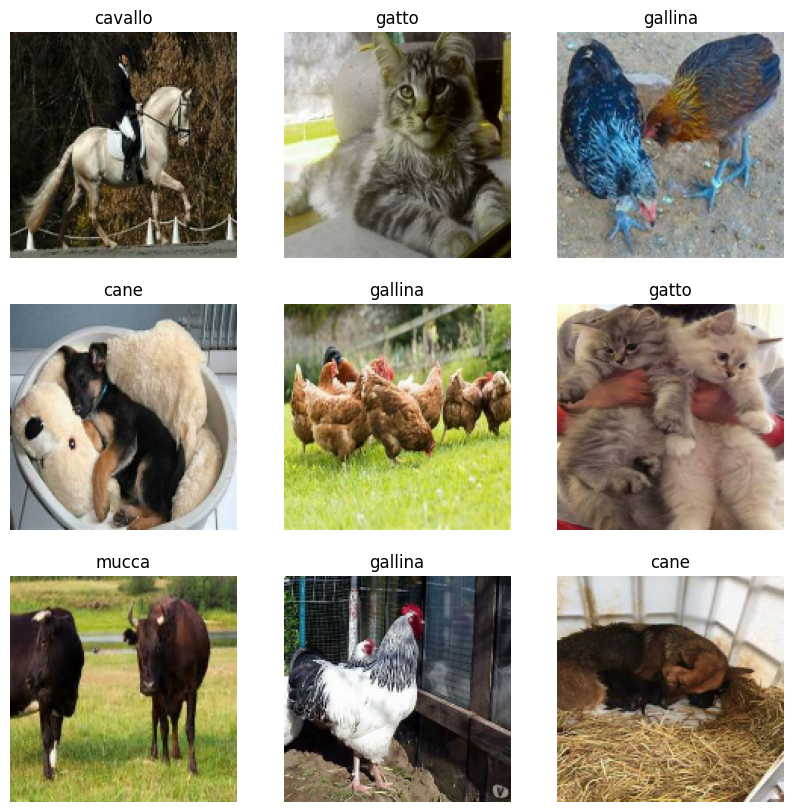

In [28]:
# Print a summary of the image classes with an image of each class.
# We will extract 1 image of the training set.

plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
  for i in range(len(class_names) - 1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model training

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

- Because we are working with images, the images are in the [0, 255] range.
- We therefore want to normalize the data to values from [0, 1].
- That way, the model will be more pertinent.


In [30]:
from keras.layers import Dense, Conv2D, Input, Flatten, Dropout, MaxPooling2D, Rescaling
from keras.models import Sequential

In [31]:
num_classes = len(class_names)

# Model creation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1)
], name="data_augmentation")

model_1 = Sequential([
    data_augmentation,
    Rescaling(1./255, input_shape = (224, 224, 3)),
    Conv2D(16, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation = "relu"),
    Dropout(0.2),
     Dense(512, activation = "relu"),
    Dropout(0.2),
    # output Layer
    Dense(num_classes, activation = "softmax")

])

# Print the model summary
model_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │       4,735,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,895,530 (18.67 MB)

 Trainable params: 4,895,530 (18.67 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Model compilation
model_1.compile(
  optimizer='adam',
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy'])

# Model training
model_1_hist = model_1.fit(
  train_ds,
  validation_data = test_ds,
  batch_size=64,
  epochs=10
)

Epoch 1/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.2675 - loss: 2.0410 - val_accuracy: 0.4677 - val_loss: 1.5761
Epoch 2/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4807 - loss: 1.5353 - val_accuracy: 0.5407 - val_loss: 1.3623
Epoch 3/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5483 - loss: 1.3425 - val_accuracy: 0.5781 - val_loss: 1.2382
Epoch 4/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5872 - loss: 1.2223 - val_accuracy: 0.5923 - val_loss: 1.2165
Epoch 5/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6107 - loss: 1.1547 - val_accuracy: 0.6095 - val_loss: 1.1670
Epoch 6/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6309 - loss: 1.0890 - val_accuracy: 0.6022 - val_loss: 1.1956
Epoch 7/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6399 - loss: 1.0590 - val_accuracy: 0.6271 - val_loss: 1.1143
Epoch 8/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6598 - loss: 1.0097 - 

## Model evaluation

### Retrieve the keys

In [33]:
print(model_1_hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


### Print the graph

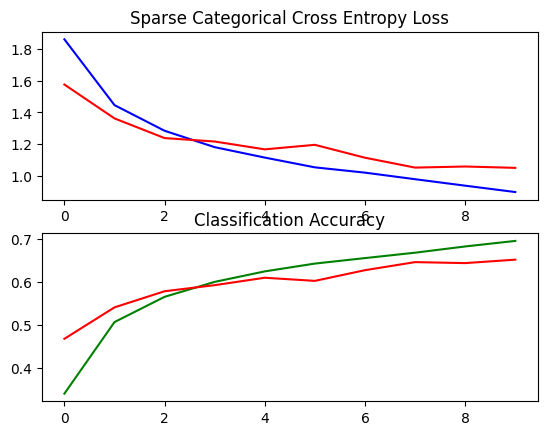

In [34]:
plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss')
plt.plot(model_1_hist.history['loss'], color='blue', label='train')
plt.plot(model_1_hist.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(model_1_hist.history['accuracy'], color='green', label='train')
plt.plot(model_1_hist.history['val_accuracy'], color='red', label='val')
plt.show()

### Evaluate the model

In [35]:
test_loss, test_acc = model_1.evaluate(test_ds, verbose=1)
print('Test loss => ', test_loss)
print('Test accuracy => ', test_acc)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6539 - loss: 1.0502
Test loss =>  1.0503075122833252
Test accuracy =>  0.6515093445777893


### Test the predictions

In [36]:
import numpy as np
predictions = model_1.predict(test_ds)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2617, 10)


### Print confusion matrix

In [37]:
from sklearn.metrics import confusion_matrix

# Extract ground truth labels from the test dataset
gt = []
for _, labels_batch in test_ds:
    gt.extend(labels_batch.numpy())

gt = np.array(gt)  # Convert gt to a NumPy array

# Calculate and print the confusion matrix
cm = confusion_matrix(gt, predictions)
print(cm)

[[279  39  35  14  26  12  12  43  13  28]
 [  7 178  13  12   7   1  22  18   4   4]
 [  7  12  87   2   7   0   4  20   4   6]
 [  3   2   1 195   5   1   1   0   4   1]
 [  6   5   3  16 249   1   1   5   6  10]
 [ 33   2   3  13   8  50   1   4  14  14]
 [ 11  23  14   2   2   1  65  37   3   4]
 [ 12  12  11   4  14   1  13 129   4   5]
 [  6   4   5  71  10   1   0  10 342  11]
 [ 12   2   7  12  12   9   1  14  17 131]]


Save the model

In [38]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [39]:
model_1.save("/content/drive/MyDrive/Joao.keras")

In [40]:
from keras import layers
from tensorflow.keras.models import Sequential

base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

base_model.trainable = False

model_tl = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])


In [41]:
model_tl.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0011),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

model_tl.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,396,786 (81.62 MB)

 Trainable params: 531,210 (2.03 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [42]:
history_tl = model_tl.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

Epoch 1/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 69s 149ms/step - accuracy: 0.3151 - loss: 2.1634 - val_accuracy: 0.4436 - val_loss: 1.6366
Epoch 2/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.4745 - loss: 1.5251 - val_accuracy: 0.4692 - val_loss: 1.5930
Epoch 3/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.5433 - loss: 1.3279 - val_accuracy: 0.4578 - val_loss: 1.6327
Epoch 4/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.6000 - loss: 1.1661 - val_accuracy: 0.4681 - val_loss: 1.6936
Epoch 5/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.6509 - loss: 1.0128 - val_accuracy: 0.4673 - val_loss: 1.7751
Epoch 6/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.6969 - loss: 0.8834 - val_accuracy: 0.4700 - val_loss: 1.8631
Epoch 7/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.7416 - loss: 0.7554 - val_accuracy: 0.4662 - val_loss: 1.9852
Epoch 8/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.7793 - loss: 0

In [43]:
test_loss, test_acc = model_1.evaluate(test_ds, verbose=1)
print('Test loss => ', test_loss)
print('Test accuracy => ', test_acc)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6539 - loss: 1.0502
Test loss =>  1.0503075122833252
Test accuracy =>  0.6515093445777893
